In [1]:
!pip install tensorflow  tensorflow-datasets ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.4 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteGO97ZY/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteGO97ZY/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


## 2. Viz data and build dataset

In [5]:
import numpy as np

# set up connection aka iterator
dataiterator = ds.as_numpy_iterator()
# getting data out of pipeline
dataiterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

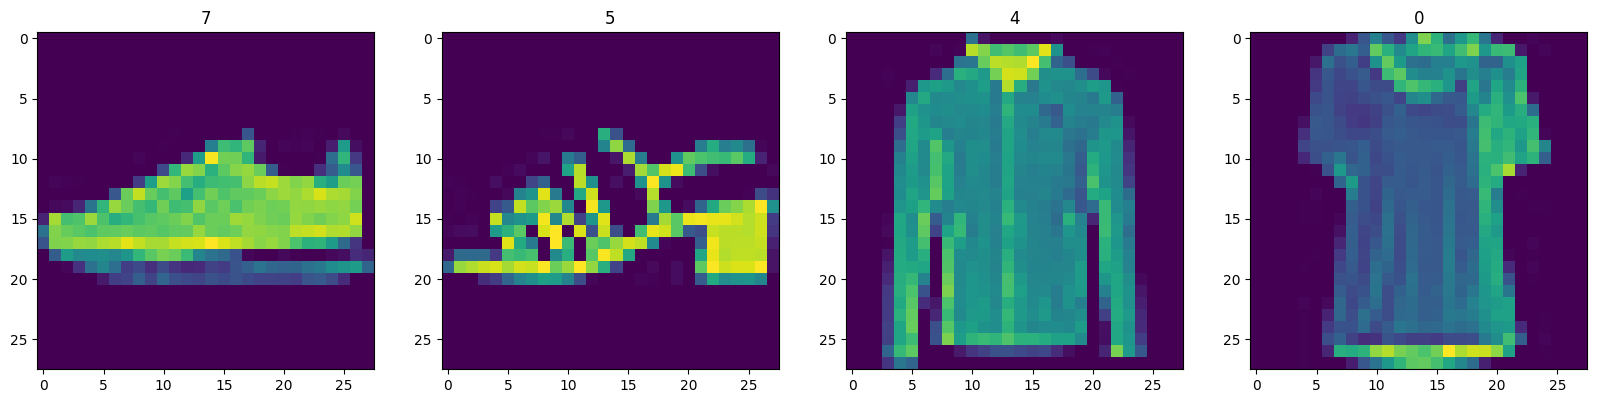

In [9]:
fig , ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
  #grab an image and label
  sample = dataiterator.next()
  # plot the image using a specific subplot
  ax[idx].imshow(np.squeeze(sample['image']))
  # appending the image label as the plot title
  ax[idx].title.set_text(sample['label'])

In [10]:
# scale and return images only
def scale_images(data):
  image = data['image']
  return image / 255

In [11]:
ds = tfds.load('fashion_mnist', split='train')
# running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images)
# cache the dataset for that batch
ds = ds.cache()
# shuffle it up
ds = ds.shuffle(60000)
# batch into 128 images per sample
ds = ds.batch(128)
# reduce the liklihood of bottlencking
ds = ds.prefetch(64)

In [12]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

## 3. Build the Neural Network

### 3.1 Import modelling components

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

### 3.2 Build generator

In [29]:
from keras.src.metrics.confusion_metrics import activations
def build_generator():
  model = Sequential()

  # takes in random values and reshapes it to 7x7x128
  #beginnings of a renerated image
  model.add(Dense(7*7*128, input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  # upsampling block 1
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  # upsampling block 2
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  # convolutional block 1
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

  # convolutional block 2
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

  # conv layer to get to one channel
  model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))


  return model

In [32]:
generator = build_generator()
generator.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_6 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_9 (UpSamplin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

In [41]:
img = generator.predict(np.random.randn(4, 128,  1))
img

1/1 [==============================] - 0s 20ms/step


array([[[[0.50265026],
         [0.5116759 ],
         [0.5154646 ],
         ...,
         [0.50230825],
         [0.501753  ],
         [0.5029397 ]],

        [[0.5056511 ],
         [0.51383156],
         [0.5154419 ],
         ...,
         [0.49869686],
         [0.5008931 ],
         [0.49844572]],

        [[0.502263  ],
         [0.517296  ],
         [0.51886916],
         ...,
         [0.5147496 ],
         [0.49955028],
         [0.49800238]],

        ...,

        [[0.49731806],
         [0.50106984],
         [0.5012767 ],
         ...,
         [0.5022732 ],
         [0.500378  ],
         [0.4993087 ]],

        [[0.4972087 ],
         [0.49970597],
         [0.49089682],
         ...,
         [0.49485606],
         [0.50096804],
         [0.5005393 ]],

        [[0.49781495],
         [0.5005344 ],
         [0.49755746],
         ...,
         [0.49722055],
         [0.5013279 ],
         [0.500639  ]]],


       [[[0.5141903 ],
         [0.5090522 ],
         [0.49

In [42]:
img.shape

(4, 28, 28, 1)

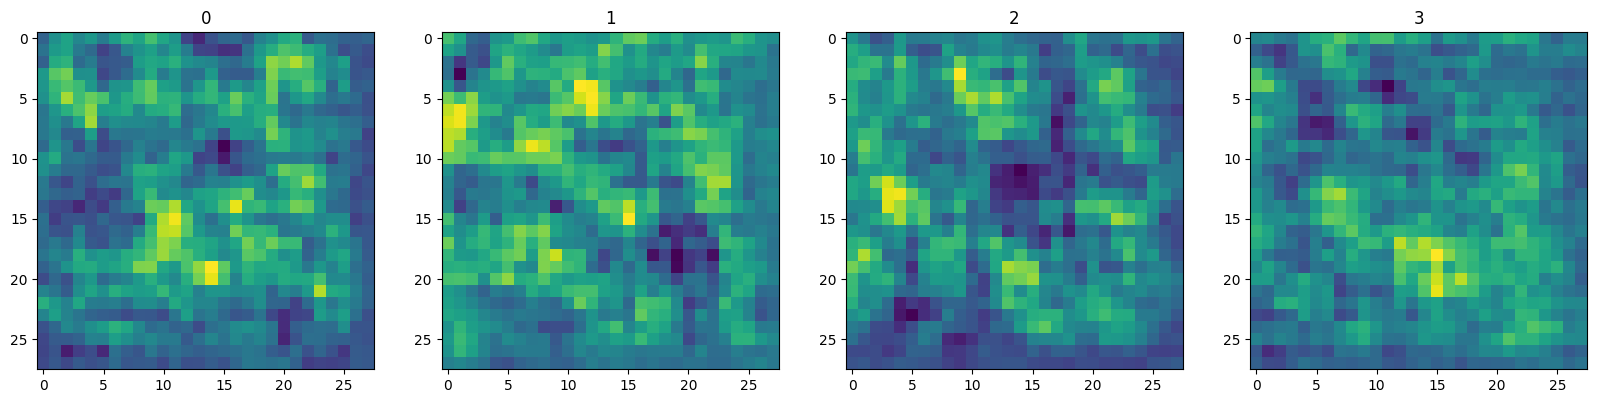

In [43]:
gig, ax = plt.subplots(ncols=4, figsize=(20,20))

for idx, img in enumerate(img):
  # plot the image using a specific subplot
  ax[idx].imshow(np.squeeze(img))
  # appending the image label as the plot title
  ax[idx].title.set_text(idx)


### Build discrimi